In [7]:
"""
           ======================================================
           =                DATA CLEANING                       =
           ======================================================
"""
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
# Importing the dataset 
df = pd.read_csv('/workspaces/FUTURE_ML_01/data/mock_kaggle.csv')

# the data column change to English for understanding these are the original portuguese headers of the data set
# which the translations makes analysis easier
df = df.rename(columns={
    'data':'Date',
    'venda':'Sales',
    'estoque':'Stock',
    'preco':'Price'
})

# making the date proper date time objects allows python to understand months, years and seasons 
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by Date
# Time-series models require data to be in chronological order
df = df.sort_values('Date').reset_index(drop=True)

# Daily Aggregation. It is used to transform "transactional data" (multiple rows per day) into "time-series data" (one single row per day).
# Machine Learning models for forecasting (like Prophet or ARIMA) require a consistent timeline. 
# They need to see exactly one data point per day to understand the trend correctly.
# If there are multiple entries for the same day, we sum them up
df_cleaned = df.groupby('Date').agg({
    'Sales': 'sum',
    'Stock': 'last', # Take the stock level at the end of the day
    'Price': 'mean'  # Take the average price for that day
}).reset_index()

# 6. Save the cleaned data to a new file
df_cleaned.to_csv('cleaned_retail_data.csv', index=False)
print("Data cleaning complete!")
print(f"Dataset range: {df_cleaned['Date'].min()} to {df_cleaned['Date'].max()}")
print(df_cleaned.head())


Data cleaning complete!
Dataset range: 2014-01-01 00:00:00 to 2016-07-31 00:00:00
        Date  Sales  Stock  Price
0 2014-01-01      0   4972   1.29
1 2014-01-02     70   4902   1.29
2 2014-01-03     59   4843   1.29
3 2014-01-04     93   4750   1.29
4 2014-01-05     96   4654   1.29


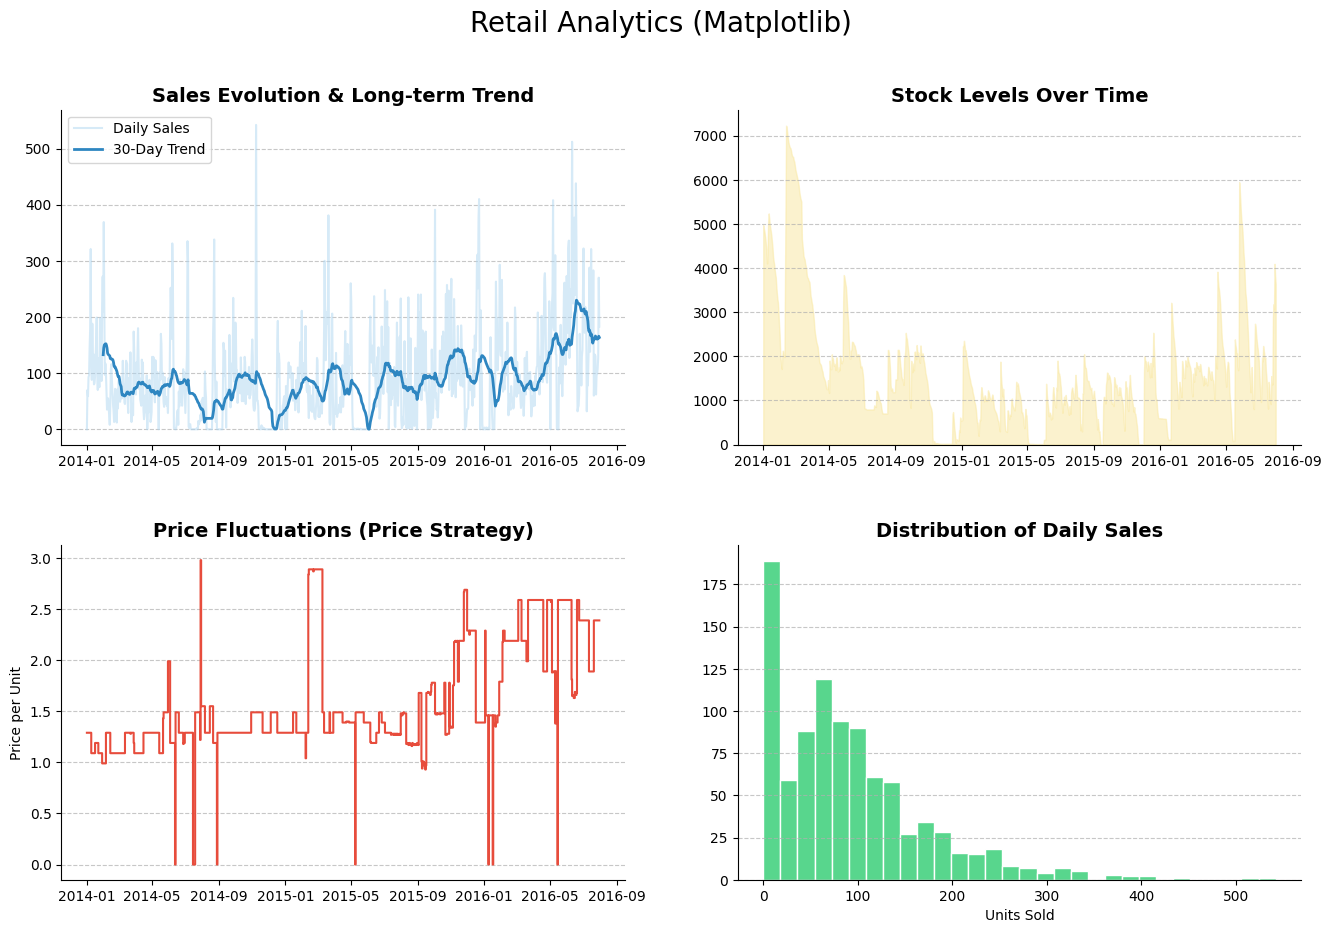

In [2]:
"""
                 ======================================================
                 =          EDA & VISUALIZATION                       =
                 ======================================================
"""
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned data
df = pd.read_csv('cleaned_retail_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Create a figure with a grid layout
fig = plt.figure(figsize=(16, 10))
grid = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.2)

# 1. Sales Trend with 30-Day Moving Average
ax1 = fig.add_subplot(grid[0, 0])
ax1.plot(df['Date'], df['Sales'], color='#AED6F1', alpha=0.5, label='Daily Sales')
ax1.plot(df['Date'], df['Sales'].rolling(window=30).mean(), color='#2E86C1', linewidth=2, label='30-Day Trend')
ax1.set_title('Sales Evolution & Long-term Trend', fontsize=14, fontweight='bold')
ax1.legend()

# 2. Stock vs. Sales (Inventory Efficiency)
ax2 = fig.add_subplot(grid[0, 1])
ax2.stackplot(df['Date'], df['Stock'], color='#F9E79F', labels=['Inventory Level'], alpha=0.5)
ax2.set_title('Stock Levels Over Time', fontsize=14, fontweight='bold')

# 3. Price over time
ax3 = fig.add_subplot(grid[1, 0])
ax3.step(df['Date'], df['Price'], color='#E74C3C', where='post', linewidth=1.5)
ax3.set_title('Price Fluctuations (Price Strategy)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Price per Unit')

# 4. Sales Distribution (Histogram)
ax4 = fig.add_subplot(grid[1, 1])
ax4.hist(df['Sales'], bins=30, color='#58D68D', edgecolor='white')
ax4.set_title('Distribution of Daily Sales', fontsize=14, fontweight='bold')
ax4.set_xlabel('Units Sold')

# General styling
for ax in [ax1, ax2, ax3, ax4]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Retail Analytics (Matplotlib)', fontsize=20, y=0.98)
plt.savefig('matplotlib_eda_dashboard.png', dpi=300)
plt.show()

In [3]:
"""
======================================================
=               FEATURE ENGINEERING                  =
======================================================
"""
import pandas as pd
import numpy as np

# Load the cleaned data from your previous task
df = pd.read_csv('cleaned_retail_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

# 1. Time-Based Features
# Extracting these allows the model to find "Seasonality" (e.g., higher sales in Dec)
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.dayofweek # 0=Monday, 6=Sunday

# 2. Binary Features (Flags)
# Retail sales usually spike on weekends
df['Is_Weekend'] = df['Date'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)
# Manual list of holiday dates
manual_holidays = [
    '2023-01-01', '2023-04-21', '2023-05-01', 
    '2023-09-07', '2023-10-12', '2023-11-02', 
    '2023-11-15', '2023-12-25'
]

df['Is_Holiday'] = df['Date'].dt.strftime('%Y-%m-%d').isin(manual_holidays).astype(int)

# 3. Lag Features
# In retail, what happened yesterday often predicts what happens today
df['Sales_Lag_1'] = df['Sales'].shift(1) # Sales from 1 day ago
df['Sales_Lag_7'] = df['Sales'].shift(7) # Sales from the same day last week

# 4. Rolling Window Features
# This calculates the "moving average" to smooth out noise
df['Rolling_Mean_7'] = df['Sales'].rolling(window=7).mean()

# 5. Price Change
# Helps the model understand if a price drop caused a sales spike
df['Price_Diff'] = df['Price'].diff()

# Clean up: The first few rows will have "NaN" because of the lags/rolling
df = df.fillna(0)

# Save the featured dataset
df.to_csv('featured_retail_data.csv', index=False)

print("✅ Feature Engineering Complete!")
print(df[['Date', 'Sales', 'Is_Weekend', 'Sales_Lag_7', 'Rolling_Mean_7']].head(10))

✅ Feature Engineering Complete!
        Date  Sales  Is_Weekend  Sales_Lag_7  Rolling_Mean_7
0 2014-01-01      0           0          0.0        0.000000
1 2014-01-02     70           0          0.0        0.000000
2 2014-01-03     59           0          0.0        0.000000
3 2014-01-04     93           1          0.0        0.000000
4 2014-01-05     96           1          0.0        0.000000
5 2014-01-06    145           0          0.0        0.000000
6 2014-01-07    179           0          0.0       91.714286
7 2014-01-08    321           0          0.0      137.571429
8 2014-01-09    125           0         70.0      145.428571
9 2014-01-10     88           0         59.0      149.571429
